In [1]:
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

open problems:
    - use multiprocessing to compute several trajectories at the same time

In [2]:
def collect_data(sess, batch_size, gamma=0.99, debug=False):
    # make some empty lists for logging.
    batch_obs = []          # for observations
    batch_acts = []         # for actions
    batch_weights = []      # for R(tau) weighting in policy gradient
    batch_rets = []         # for measuring episode returns
    batch_lens = []         # for measuring episode lengths

    # reset episode-specific variables
    obs = env.reset()       # first obs comes from starting distribution
    done = False            # signal from environment that episode is over
    ep_rews = []            # list for rewards accrued throughout ep

    # collect experience by acting in the environment with current policy
    while True:
        # save obs
        batch_obs.append(obs.copy())

        # act in the environment
        act = sess.run(actions, {obs_ph: obs.reshape(1,-1)})[0]
        obs, rew, done, info = env.step(act)
        
        # save action, reward
        batch_acts.append(act)
        ep_rews.append(rew)

        if done:
            # if episode is over, record info about episode
            ep_ret, ep_len = sum(ep_rews), len(ep_rews)
            batch_rets.append(ep_ret)
            batch_lens.append(ep_len)
            
            # the weight for each logprob(a_t|s_t) is reward-to-go from t
            if ep_len == 200:
                bootstrap_value = sess.run(state_value, {obs_ph:obs.reshape(1,-1)})[0][0]
            else:
                bootstrap_value = 0
            batch_weights += compute_rewards_to_go(ep_rews, gamma, bootstrap_value)

            # reset episode-specific variables
            obs, done, ep_rews = env.reset(), False, []

            # end experience loop if we have enough of it
            if len(batch_obs) > batch_size:
                break
    return batch_obs, batch_acts, batch_weights, batch_rets, batch_lens

def compute_rewards_to_go(rewards, gamma, bootstrap_value):
    rewards_to_go = [rewards[-1] + gamma*bootstrap_value]
    for rew in rewards[:-1][::-1]:
        tmp = rewards_to_go[-1]
        rewards_to_go.append(rew + gamma * tmp)
    return rewards_to_go[::-1]



## Build Computational Graph

In [3]:
env = gym.make('LunarLander-v2')
obs_dim = env.observation_space.shape[0]
n_acts = 4

# placeholder
obs_ph = tf.placeholder(shape=(None, obs_dim), dtype=tf.float32)
act_ph = tf.placeholder(shape=(None,), dtype=tf.int32)
weights_ph = tf.placeholder(shape=(None,), dtype=tf.float32)

# make core of policy network
mlp = tf.keras.models.Sequential()
mlp.add(tf.keras.layers.Dense(30, activation='tanh'))
mlp.add(tf.keras.layers.Dense(30, activation='tanh'))
mlp.add(tf.keras.layers.Dense(n_acts))
logits = mlp(obs_ph)

# make core of state-action-value function network
# mlp_action_val = tf.keras.models.Sequential()
# mlp_action_val.add(tf.keras.layers.Dense(50, activation='tanh'))
# mlp_action_val.add(tf.keras.layers.Dense(50, activation='tanh'))
# mlp_action_val.add(tf.keras.layers.Dense(n_acts))
# state_action_values = mlp_action_val(obs_ph)

# make state-value function network
mlp_val = tf.keras.models.Sequential()
mlp_val.add(tf.keras.layers.Dense(50, activation='relu'))
mlp_val.add(tf.keras.layers.Dense(50, activation='relu'))
mlp_val.add(tf.keras.layers.Dense(1))
state_value = mlp_val(obs_ph)

# make action selection op (outputs int actions, sampled from policy)
actions = tf.squeeze(tf.multinomial(logits=logits,num_samples=1), axis=1)

# make loss function whose gradient, for the right data, is policy gradient
action_masks = tf.one_hot(act_ph, n_acts)
log_probs = tf.reduce_sum(action_masks * tf.nn.log_softmax(logits), axis=1)
# action_values = tf.reduce_sum(action_masks * state_action_values, axis=1)
# baseline = tf.reduce_sum(state_action_values * tf.nn.softmax(logits))
loss = -tf.reduce_mean((weights_ph - state_value) * log_probs)



# state value loss function
# loss_action_value = tf.reduce_mean((action_values - weights_ph)**2)
loss_state_value = tf.reduce_mean((state_value - weights_ph)**2)

In [4]:
%%time
# main
# env = gym.make('CartPole-v0')

# global_step = tf.Variable(0, trainable=False)
# starter_learning_rate = 0.01
# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            50, 0.90, staircase=True)
# # Passing global_step to minimize() will increment it at each step.
# policy_learning_step = (
#     tf.train.AdamOptimizer(learning_rate)
#     .minimize(loss, global_step=global_step)
# )

optimizer = tf.train.AdamOptimizer(0.003)
# optimizer_action_value = tf.train.AdamOptimizer(0.001)
optimizer_state_value = tf.train.AdamOptimizer(0.001)
train = optimizer.minimize(loss)
# train_action_value = optimizer_action_value.minimize(loss_action_value)
train_state_value = optimizer_state_value.minimize(loss_state_value)

sess = tf.Session()
n_runs = 3
n_epochs = 300
episode_returns = [[] for x in range(n_runs)]

for j in range(n_runs):
    sess.run(tf.global_variables_initializer())
    for i in range(n_epochs):
        tmp1, tmp2, tmp3, batch_rets, batch_len = collect_data(sess, 4000 ,debug=False)
        episode_returns[j].extend(batch_rets)
        print(i, np.mean(batch_rets), np.min(batch_rets), np.max(batch_rets))
        sess.run([train],feed_dict={
                                        obs_ph: np.array(tmp1),
                                        act_ph: np.array(tmp2),
                                        weights_ph: np.array(tmp3)
                                     })
        for _ in range(10):
            sess.run([train_state_value],feed_dict={
                                    obs_ph: np.array(tmp1),
                                    act_ph: np.array(tmp2),
                                    weights_ph: np.array(tmp3)
                                 })
        v = sess.run([state_value], feed_dict={
                                        obs_ph: np.array(tmp1),
                                        act_ph: np.array(tmp2),
                                        weights_ph: np.array(tmp3)
                                     })
        print("Value function mean and std:", np.mean(v), np.std(v))
        #print('Optimized')
    print('Evaluation')
    tmp1, tmp2, tmp3, batch_rets, batch_len = collect_data(sess, 5, debug=True)
    print(np.mean(batch_len), np.min(batch_len), np.max(batch_len))
    print()

0 -207.3877341149228 -472.2678841260707 -55.964719905655514
Value function mean and std: -0.64210635 0.16326696
1 -258.7721956416118 -629.4195860861812 -28.997781551806952
Value function mean and std: -1.0188698 0.25015122
2 -188.3086093295001 -542.021590327354 -15.74931671391711
Value function mean and std: -1.3592087 0.2791471
3 -246.48622990170514 -524.3676490664911 -17.6711441117112
Value function mean and std: -2.0162575 0.46986768
4 -178.40978877622862 -473.79907894596926 27.779582898998513
Value function mean and std: -2.6441543 0.49788693
5 -183.18061052757045 -396.9391416046251 -21.10900535689794
Value function mean and std: -3.4987853 0.6588728
6 -189.38727301018162 -642.0465812918256 -12.034619309168235
Value function mean and std: -4.7391148 1.0231119
7 -170.4442753642717 -425.17204579896224 9.239326582948863
Value function mean and std: -6.174581 1.2428908
8 -179.45803327950176 -477.3915551024641 -3.4539694625812984
Value function mean and std: -7.8949437 1.5310615
9 -152.

75 -75.66701507954305 -303.12194934495926 49.94392186009259
Value function mean and std: -24.433617 2.2146883
76 -51.08211794147263 -263.5642137923594 80.92904849777088
Value function mean and std: -21.728544 3.7486157
77 -37.85893974642498 -284.9412471085608 60.674574603042586
Value function mean and std: -20.42407 3.406648
78 -39.975479151312065 -248.57892329950184 77.20114910116546
Value function mean and std: -18.92652 3.3318803
79 -27.48747362905791 -210.3249808645548 60.82628929571199
Value function mean and std: -16.804743 3.2442558
80 -50.8687375368312 -188.42898907134423 30.22792204000183
Value function mean and std: -17.317638 2.3696291
81 -49.70738662093986 -284.30969089651865 26.723660653362757
Value function mean and std: -17.654945 1.8624696
82 -7.863719610637118 -116.29759056403894 82.78731364318895
Value function mean and std: -15.479503 2.5722525
83 -36.543817807483855 -227.42749085027071 43.19690420370972
Value function mean and std: -14.075157 2.4629796
84 -32.688431

Value function mean and std: 1.8415858 0.5259732
150 76.35055160930145 -28.911243814560663 140.5959996955272
Value function mean and std: 2.3452206 0.62991655
151 15.17487956533298 -66.49363424926383 120.80443295531201
Value function mean and std: 2.5456574 0.7634428
152 24.041764232723686 -71.68962949931253 140.99279664232103
Value function mean and std: 2.3466132 0.700923
153 51.0130449983389 -32.114466632087996 158.20595183383747
Value function mean and std: 2.4562082 0.7312546
154 17.327379031553345 -228.8557501531051 192.0507998105703
Value function mean and std: 2.3981116 0.71460193
155 35.588242876317345 -54.082919412643406 160.63657486709656
Value function mean and std: 2.4170585 0.7106619
156 125.67270422462923 92.62642854800592 154.0952585252331
Value function mean and std: 2.9434571 0.69128007
157 97.6099225074915 41.54609281328086 190.10368469871366
Value function mean and std: 3.890539 0.8373224
158 -5.691577332405158 -161.31318482004073 88.09365574176725
Value function me

225 137.46321965475644 -54.29314642645662 266.52702353401946
Value function mean and std: 33.176304 4.3289294
226 113.92301461369011 -57.26959100959402 288.10556688177655
Value function mean and std: 27.266254 3.6788712
227 129.4367694907043 -116.44904730370439 273.4074918145767
Value function mean and std: 24.12787 4.0107846
228 218.80850985432076 41.32916843322673 300.63396107643666
Value function mean and std: 28.078522 4.6134615
229 169.16816256326817 -133.9885850391548 293.57155470263547
Value function mean and std: 30.338919 4.289204
230 201.04510317113693 -11.603702442479744 279.7545814150576
Value function mean and std: 32.895866 3.9836369
231 169.77571099823274 -182.02117281916526 286.4651677444424
Value function mean and std: 35.57431 4.184553
232 208.39291267015133 -30.56181583550132 276.39490369015726
Value function mean and std: 39.04956 3.897258
233 215.1612540522111 27.313128679752353 266.4279044382678
Value function mean and std: 45.673244 4.2692657
234 186.629054763237

Value function mean and std: -0.13713986 0.07846045
1 -248.81010758139416 -515.9097302333977 14.78350696042024
Value function mean and std: -0.5639345 0.1481643
2 -259.5112709897482 -561.9839609980988 -80.0237273270558
Value function mean and std: -1.0537926 0.29656303
3 -181.72141608237223 -546.175407554941 -0.40155465570202864
Value function mean and std: -1.5480081 0.41818908
4 -176.48867581825888 -607.270696192187 20.876248884395537
Value function mean and std: -2.0653477 0.5112783
5 -138.17941512002903 -323.2110944347672 -8.679367418195667
Value function mean and std: -2.6112356 0.46195993
6 -134.46262283390809 -384.398144617408 -3.424891905143184
Value function mean and std: -3.4013846 0.54723585
7 -137.64933479261214 -420.9656599650491 -5.790717688483198
Value function mean and std: -4.389793 0.67463183
8 -152.06127275974868 -380.39549014170007 13.257708070927166
Value function mean and std: -5.8926845 0.8820245
9 -154.27159581285795 -381.80211452704117 -10.535736624218075
Value

KeyboardInterrupt: 

## Visualization

Text(0.5, 1.0, '')

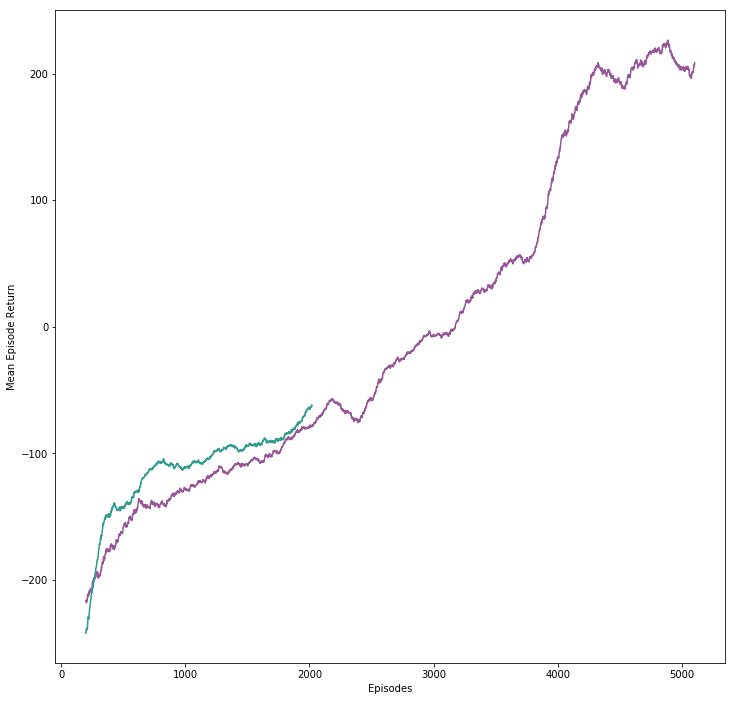

In [6]:
# smooth episode returns
t = 200
episode_mean_returns = [[np.mean(episode_returns[j][i-t:i]) for i in range(t, len(episode_returns[j]))] \
                            for j in range(n_runs)]

fig = plt.figure(figsize=(12,12))
for i in range(n_runs):
    plt.plot(range(t,len(episode_mean_returns[i])+t), episode_mean_returns[i], color=np.random.rand(3))
plt.xlabel('Episodes')
plt.ylabel('Mean Episode Return')
plt.title('')